In [197]:
import sys; sys.path.append('..')
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from src.utils.metrics import (
    compute_average_accuracy,
    compute_forgetting_measure,
    compute_learning_curve_area,
    compute_ausuc,
    compute_ausuc_matrix,
    compute_individual_accs_matrix,
    compute_task_transfer_matrix,
    compute_seen_classes_acc_history,
    compute_unseen_classes_acc_history,
    compute_joined_ausuc_history,
    compute_acc_for_classes
)


def compute_average_taskwise_accucy(logits_history, targets, class_splits):
    assert len(logits_history) == len(class_splits) + 1
    
    acc_matrix = compute_individual_accs_matrix(logits_history[1:], targets, class_splits)
    acc_matrix = np.tril(acc_matrix)
    accs = acc_matrix.sum(axis=1) / np.arange(1, len(class_splits) + 1)
    
    return accs

In [338]:
# dataset, tasks = 'CIFAR100', np.arange(1, 11)
dataset = 'CUB'
# dataset = 'AwA2'
ablation = True

if dataset == 'CUB':
    tasks = np.arange(1, 11)
    experiments_dir = '../cub-experiments'
    method_to_prefix = {
        "Sequential": "basic--cub--1-00001",
        "Joint": "joint--cub-hp.use_class_attrs=false-1-00001",

        "DEM-[1/2] $\\times 0.25$": "dem--cub-hp.memory.num_samples_per_class=1_hp.memory.downsample_size=128_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
        "DEM-[1/2] $\\times 2$": "dem--cub-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=128_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
        "DEM-[1/2] $\\times 4$": "dem--cub-hp.memory.num_samples_per_class=16_hp.memory.downsample_size=128_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
        "DEM-[1/2] $\\times 8$": "dem--cub-hp.memory.num_samples_per_class=32_hp.memory.downsample_size=128_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
        
        "DEM-[1/4] $\\times 0.25$": "dem--cub-hp.memory.num_samples_per_class=4_hp.memory.downsample_size=64_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
        'DEM-[1/4] $\\times 0.5$': "lm-ablation-dem--cub-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=64_hp.lowres_training.logits_matching_loss_coef=1-1-00001",

        "iCARL $\\times 5$": "icarl--cub-hp.memory.max_size=1000-1-00001",
        "iCARL $\\times 3$": "icarl--cub-hp.memory.max_size=600-1-00002",
        "A-GEM $\\times 3$": "agem--cub-hp.num_mem_samples_per_class=3-1-00001",
    }
    
    if ablation:
        method_to_prefix = {
            'DEM-[1/4] $\\times 0.5$ [no logits matching]': "lm-ablation-dem--cub-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=64_hp.lowres_training.logits_matching_loss_coef=0-1-00001",
            'DEM-[1/4] $\\times 0.5$': "lm-ablation-dem--cub-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=64_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
            'DEM-[1/2] $\\times 1$ [no logits matching]': "dem--cub-hp.memory.num_samples_per_class=4_hp.memory.downsample_size=128_hp.lowres_training.logits_matching_loss_coef=0-1-00001",
            'DEM-[1/2] $\\times 1$': "dem--cub-hp.memory.num_samples_per_class=4_hp.memory.downsample_size=128_hp.lowres_training.logits_matching_loss_coef=1-1-00002",
            'DEM-[1/2] $\\times 2$ [no logits matching]': "dem--cub-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=128_hp.lowres_training.logits_matching_loss_coef=0-1-00001",
            'DEM-[1/2] $\\times 2$': "dem--cub-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=128_hp.lowres_training.logits_matching_loss_coef=1-1-00002",
        }
elif dataset == 'AwA2':
    tasks = np.arange(1, 6)
    experiments_dir = '../awa-experiments'
    method_to_prefix = {
        "Joint": "joint--awa--1-00001",
        "Sequential": "basic--awa-hp.use_class_attrs=false-1-00001",
        "DEM-[1/2] $\\times 0.5$": 'dem--awa-hp.memory.num_samples_per_class=2_hp.memory.downsample_size=128-1-00001',
        "DEM-[1/4] $\\times 2$": "dem--awa-hp.memory.num_samples_per_class=32_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
        "DEM-[1/8] $\\times 1$": "dem--awa-hp.memory.num_samples_per_class=32_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1_hp.optim.kwargs.lr=0.01-1-00001",

        "iCARL $\\times 5$": "icarl--awa-hp.memory.max_size=1000-1-00001",
        "AGEM $\\times 5$": 'agem--awa-hp.num_mem_samples_per_class=5-1-00001',
    }
elif dataset == 'TinyImageNet':
    tasks = np.arange(1, 9)
    experiments_dir = '../tiny_imagenet-experiments'
    method_to_prefix = {
        "Sequential": "basic--tiny_imagenet--1-00001",
#         "Joint": "joint--tiny_imagenet--1-00001",

#         "DEM-[1/2] $\\times 0.25$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=1_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
#         "DEM-[1/2] $\\times 1$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=4_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
#         "DEM-[1/2] $\\times 2$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
#         "DEM-[1/2] $\\times 4$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=16_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
#         "DEM-[1/2] $\\times 8$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=32_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00001",

#         "DEM-[1/4] $\\times 0.625$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=1_hp.memory.downsample_size=16_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
#         "DEM-[1/4] $\\times 0.25$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=4_hp.memory.downsample_size=16_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
#         "DEM-[1/4] $\\times 0.5$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=16_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
#         "DEM-[1/4] $\\times 1$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=16_hp.memory.downsample_size=16_hp.lowres_training.logits_matching_loss_coef=1-1-00001",
#         "DEM-[1/4] $\\times 2$)": "dem--tiny_imagenet-hp.memory.num_samples_per_class=32_hp.memory.downsample_size=16_hp.lowres_training.logits_matching_loss_coef=1-1-00001",

#         "EM $\\times 1$": 'dem--tiny_imagenet-hp.memory.num_samples_per_class=1_hp.memory.downsample_size=64-1-00001',
           "EM $\\times 2$": 'dem--tiny_imagenet-hp.memory.num_samples_per_class=2_hp.memory.downsample_size=64-1-00001',
#         "EM $\\times 5$": 'dem--tiny_imagenet-hp.memory.num_samples_per_class=5_hp.memory.downsample_size=64-1-00001',
#         "AGEM $\\times 3$": 'agem--tiny_imagenet-hp.num_mem_samples_per_class=3-1-00001',
#         "DEM-[1/2] $\\times 1$)": 'dem--tiny_imagenet-hp.memory.num_samples_per_class=4_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00002',
#         "DEM-[1/2] $\\times 1$) 2":'dem--tiny_imagenet-hp.memory.num_samples_per_class=4_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00003',
#         "DEM-[1/2] $\\times 2$)": 'dem--tiny_imagenet-hp.memory.num_samples_per_class=8_hp.memory.downsample_size=32_hp.lowres_training.logits_matching_loss_coef=1-1-00001',
        "iCARL $\\times 3$":'icarl--tiny_imagenet-hp.memory.max_size=600-1-00004',
    }


find_exps = lambda prefix: [e for e in os.listdir(experiments_dir) if e.startswith(prefix)]
methods, prefixes = zip(*method_to_prefix.items())
exps = {m: find_exps(p) for m, p in zip(methods, prefixes)}

exps = {m: [e for e in exps[m] if os.path.exists(f'{experiments_dir}/{e}/custom_data/logits_history.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{experiments_dir}/{e}/custom_data/targets.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{experiments_dir}/{e}/custom_data/class_splits.npy')] for m in exps}
exps = {m: exps[m] for m in exps if len(exps[m]) > 0}
methods = list(exps.keys())

logits_histories = {m: [np.load(f'{experiments_dir}/{e}/custom_data/logits_history.npy') for e in exps[m]] for m in exps}
targets = {m: [np.load(f'{experiments_dir}/{e}/custom_data/targets.npy') for e in exps[m]] for m in exps}
class_splits = {m: [np.load(f'{experiments_dir}/{e}/custom_data/class_splits.npy', allow_pickle=True) for e in exps[m]] for m in exps}

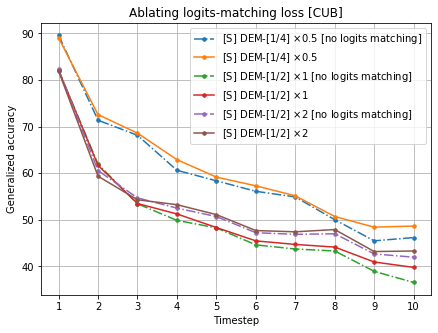

In [339]:
from matplotlib.colors import BASE_COLORS

# colors = list(BASE_COLORS.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(7, 5))
if ablation:
    plt.title(f'Ablating logits-matching loss [{dataset}]')
else:
    plt.title(f'Generalized accuracy [{dataset}]')

for i, method in enumerate(methods):
    values = [compute_seen_classes_acc_history(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
#     if '(1/4)' in method:
#         kwargs = {"marker": "*"}
#     elif '(1/2)' in method:
#         kwargs = {"marker": ".", 'markersize': 7}
    if 'DEM' in method:
        kwargs = {"marker": ".", 'markersize': 7}
    else:
        kwargs = {}
        
    if 'no' in method:
        kwargs = {**kwargs, **{'linestyle': '-.'}}
    #plt.plot(tasks, values_avg * 100, label=fr'[S] {method} (final: {values_avg[-1] * 100: .3f})', color=colors[i % len(colors)], **kwargs)
    plt.plot(tasks, values_avg * 100, label=fr'[S] {method}', color=colors[i % len(colors)], **kwargs)

plt.legend()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Timestep')
plt.ylabel('Generalized accuracy')
plt.xticks(tasks)
plt.grid()

if ablation:
    plt.savefig(f'../plots/{dataset.lower()}-generalized-acc-ablation.pdf')
else:
    plt.savefig(f'../plots/{dataset.lower()}-generalized-acc.pdf')

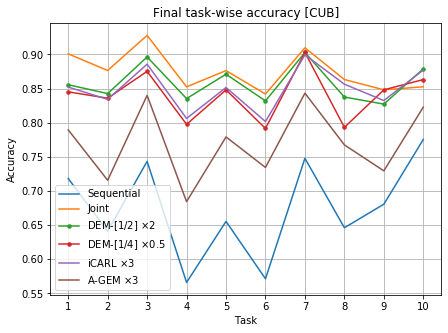

In [334]:
plt.figure(figsize=(7, 5))
plt.title(f'Final task-wise accuracy [{dataset}]')

for method in methods:
    values = [[compute_acc_for_classes(l[-1], t, cs) for cs in c] for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    
    if 'DEM' in method:
        kwargs = {"marker": ".", 'markersize': 7}
    else:
        kwargs = {}
        
    #plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})', **kwargs)
    plt.plot(tasks, values_avg, label=f'{method}', **kwargs)

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()
plt.savefig(f'../plots/{dataset.lower()}-final-accs.pdf')

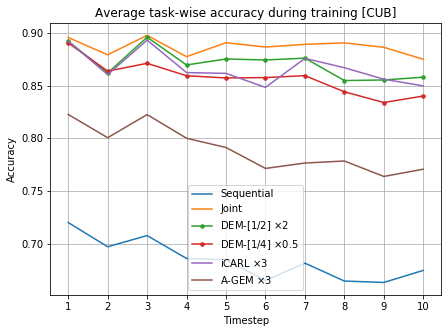

In [335]:
plt.figure(figsize=(7, 5))
plt.title(f'Average task-wise accuracy during training [{dataset}]')

for method in methods:
    values = [compute_average_taskwise_accucy(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    
    if 'DEM' in method:
        kwargs = {"marker": ".", 'markersize': 7}
    else:
        kwargs = {}
        
    #plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})', **kwargs)
    plt.plot(tasks, values_avg, label=f'{method}', **kwargs)

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()
plt.savefig(f'../plots/{dataset.lower()}-average-acc.pdf')

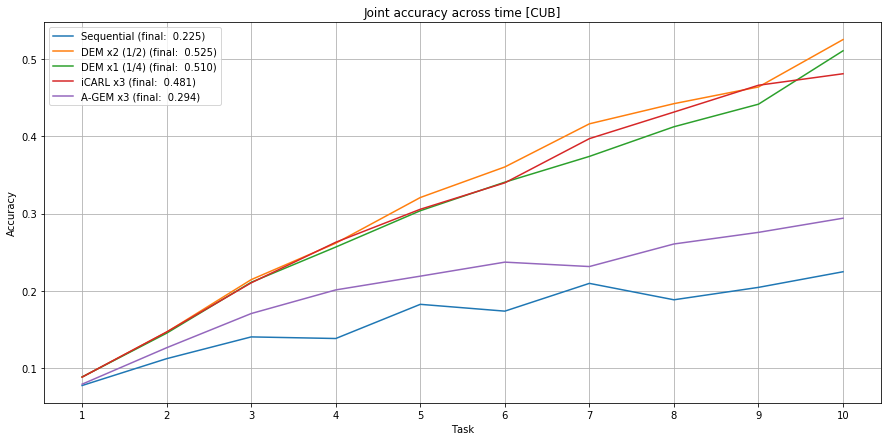

In [91]:
plt.figure(figsize=(15, 7))
plt.title(f'Joint accuracy across time [{dataset}]')

for method in methods:
    values = [(l[1:].argmax(axis=2) == t.reshape(1, -1)).mean(1) for l, t in zip(logits_histories[method], targets[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (final: {values_avg[-1]: .3f})')

# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.legend()
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

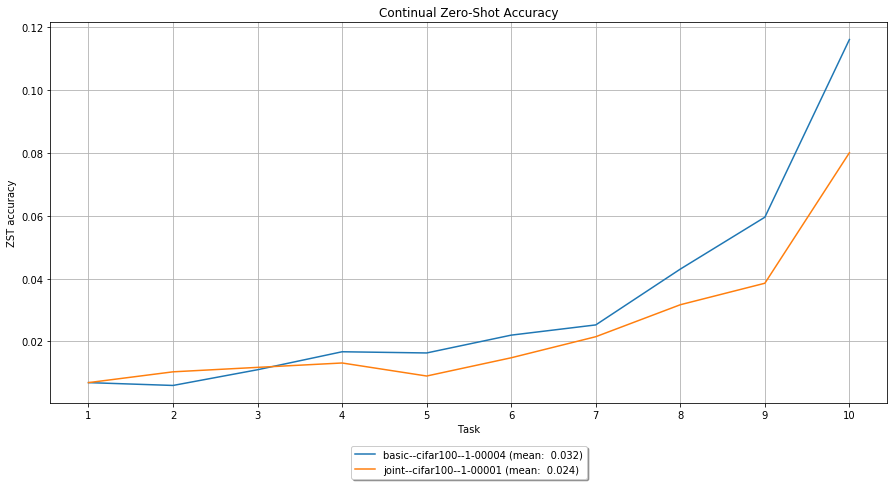

In [4]:
plt.figure(figsize=(15, 7))
plt.title('Continual Zero-Shot Accuracy')

for method in methods:
    values = [compute_unseen_classes_acc_history(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('ZST accuracy')
plt.xticks(tasks)
plt.grid()

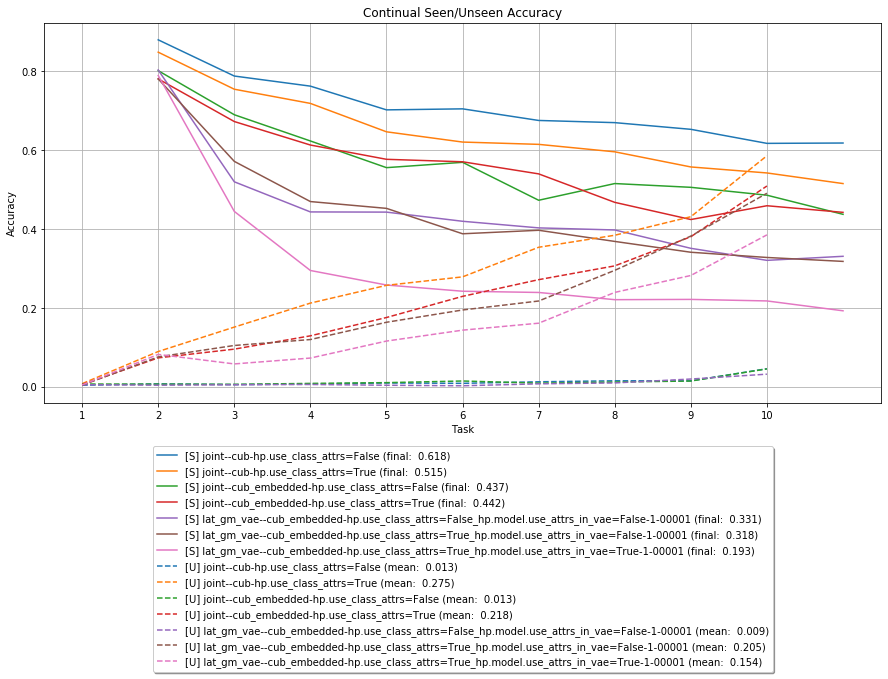

In [10]:
from matplotlib.colors import BASE_COLORS

# colors = list(BASE_COLORS.keys())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 7))
plt.title('Continual Seen/Unseen Accuracy')

for i, method in enumerate(methods):
    values = [compute_seen_classes_acc_history(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks + 1, values_avg, label=f'[S] {method} (final: {values_avg[-1]: .3f})', color=colors[i % len(colors)])
    #plt.plot(tasks, values_avg, label=f'[S] {method} (mean: {values_avg.mean(): .3f})')

for i, method in enumerate(methods):
    values = [compute_unseen_classes_acc_history(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, '--', label=f'[U] {method} (mean: {values_avg.mean(): .3f})', color=colors[i % len(colors)])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.grid()

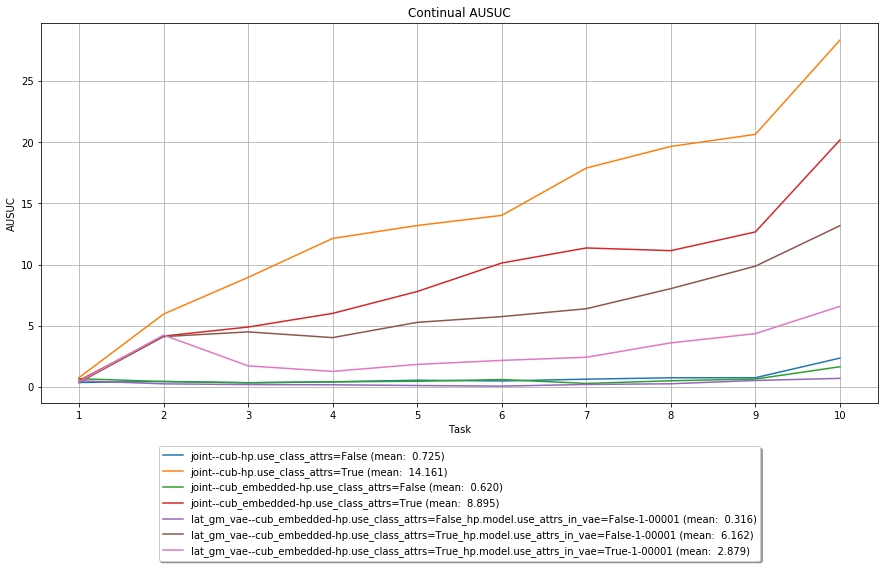

In [5]:
plt.figure(figsize=(15, 7))
plt.title('Continual AUSUC')

for method in methods:
    values = [compute_joined_ausuc_history(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_avg = np.array(values).mean(0)
    plt.plot(tasks, values_avg, label=f'{method} (mean: {values_avg.mean(): .3f})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
plt.xlabel('Task')
plt.ylabel('AUSUC')
plt.xticks(tasks)
plt.grid()

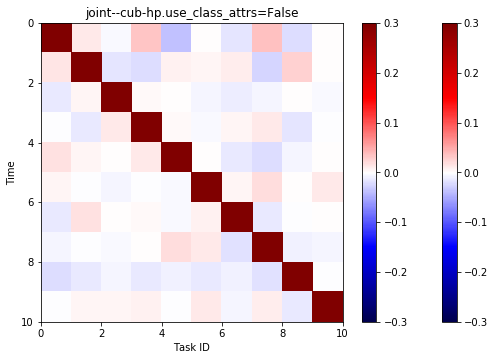

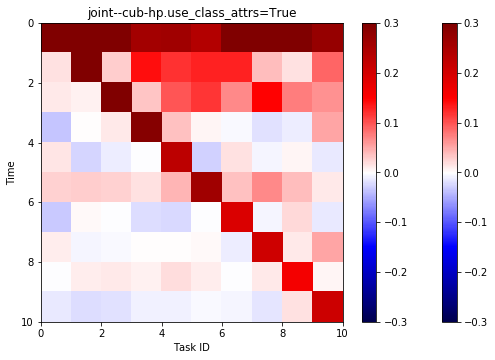

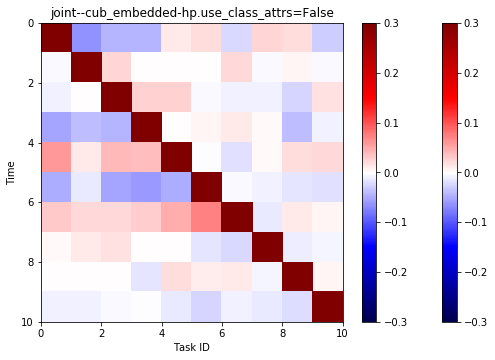

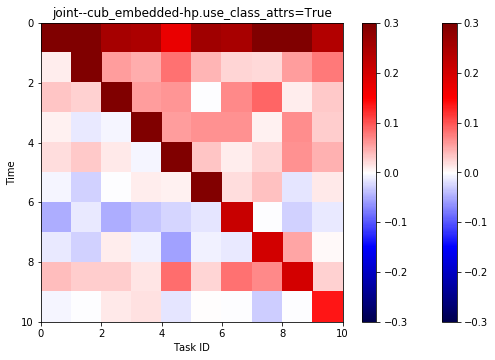

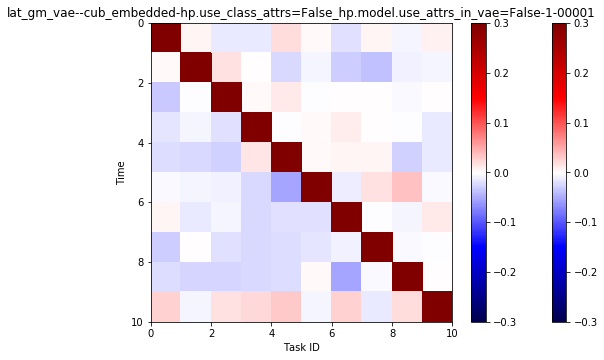

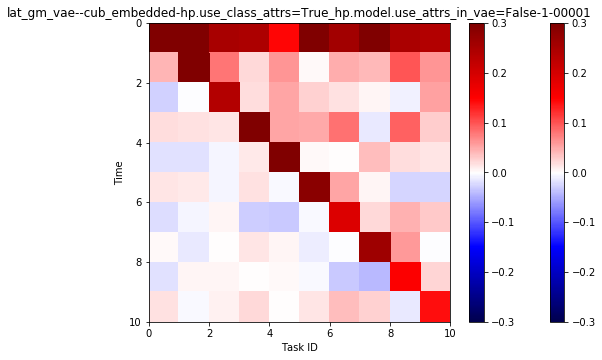

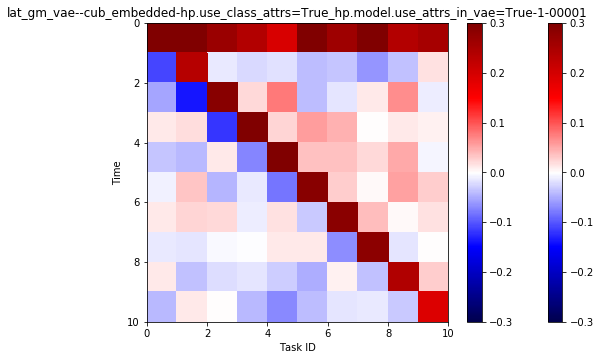

In [8]:
from tqdm import tqdm

def plot_task_transfer_matrix(values, title: str=''):
    # https://stackoverflow.com/questions/35727374/creating-a-matplotlib-heatmap-with-two-different-coloured-data-sets

    mask_red = np.triu(np.ones_like(values), k=1).astype(bool)
    mask_blue = np.tril(np.ones_like(values), k=0).astype(bool)

    values_red = np.ma.masked_where(~mask_red, values)
    values_blue = np.ma.masked_where(~mask_blue, values)

    # # Make a side-by-side plot
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    redmesh = ax.pcolormesh(values_red, cmap='seismic', vmin=-0.3, vmax=0.3)
    bluemesh = ax.pcolormesh(values_blue, cmap='seismic', vmin=-0.3, vmax=0.3)
    # plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel('Task ID')
    plt.ylabel('Time')

    # Add dual colorbars
    fig.subplots_adjust(bottom=0.05, right=0.78, top=0.88, wspace=0, hspace=0)
    cbar = fig.colorbar(redmesh)
    cbar = fig.colorbar(bluemesh)
    plt.show()


# plt.figure(figsize=(20, 5 * 2))

for i, method in enumerate(methods):
    values_acc = [compute_task_transfer_matrix(l, t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    values_acc_avg = np.array(values_acc).mean(0)
    plot_task_transfer_matrix(values_acc_avg, method)

#     plt.subplot(3, 3, i + 1)
#     plt.title(f'Task accuracies for [{method}]')
#     plt.imshow(values_acc_avg, cmap='Blues', vmin=0, vmax=1.)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);

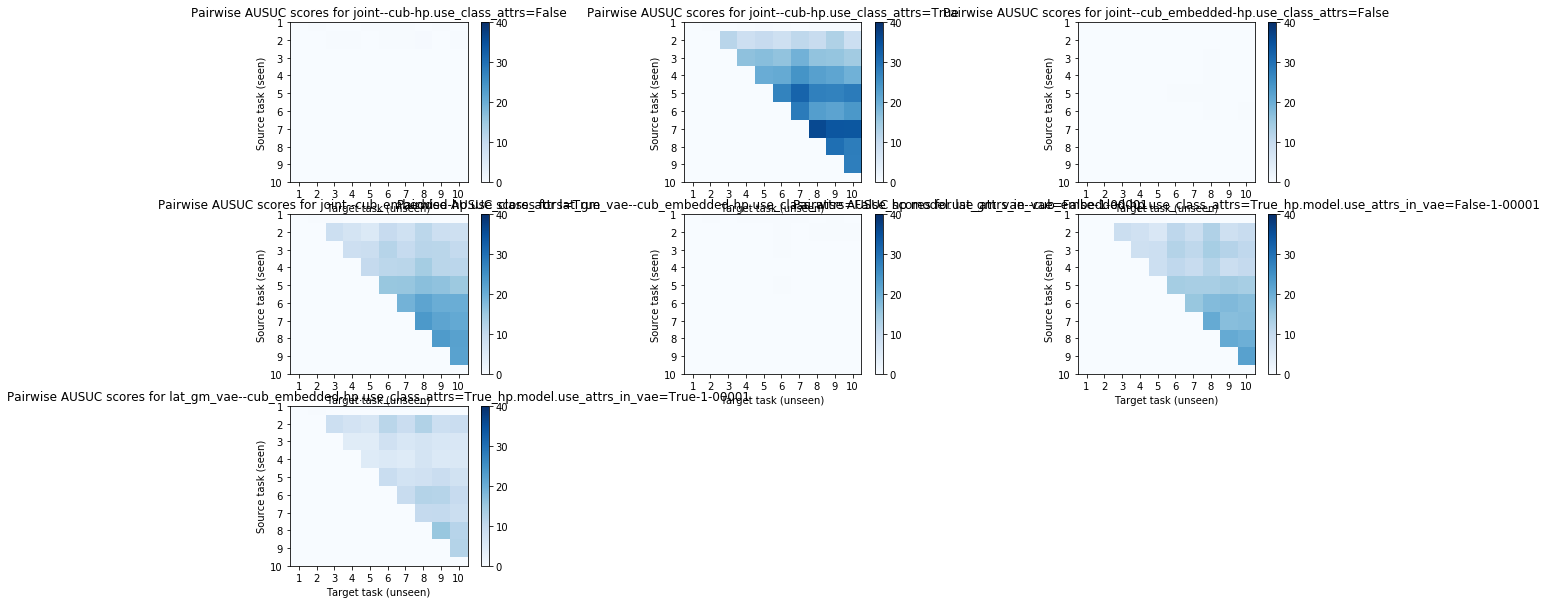

In [9]:
plt.figure(figsize=(20, 5 * 2))

for i, method in enumerate(methods):
    values_ausuc = [compute_ausuc_matrix(l[:-1], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]    
    values_ausuc_avg = np.array(values_ausuc).mean(0)
    
    plt.subplot(3, 3, i + 1)
    plt.title(f'Pairwise AUSUC scores for {method}')
    plt.imshow(np.triu(values_ausuc_avg, k=1), cmap='Blues', vmin=0, vmax=40)
    plt.colorbar(fraction=0.046, pad=0.04)
    #plt.clim(0, 100)
    plt.ylabel('Source task (seen)')
    plt.xlabel('Target task (unseen)')
    plt.xticks(tasks - 1, tasks);
    plt.yticks(tasks - 1, tasks);

In [37]:
# for method in methods:
#     values_acc = [compute_individual_accs_matrix(l[1:], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
#     values_ausuc = [compute_ausuc_matrix(l[:-1], t, c) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
    
#     values_acc_avg = np.array(values_acc).mean(0)
#     values_ausuc_avg = np.array(values_ausuc).mean(0)

#     plt.figure(figsize=(15, 7))
    
#     plt.subplot(121)
#     plt.title(f'Task accuracies for [{method}]')
#     plt.imshow(values_acc_avg, cmap='Blues', vmin=0, vmax=1.)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     #plt.clim(0, 1)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);

#     plt.subplot(122)
#     plt.title(f'Pairwise AUSUC scores for [{method}]')
#     plt.imshow(np.triu(values_ausuc_avg), cmap='Blues', vmin=0, vmax=70)
#     plt.colorbar(fraction=0.046, pad=0.04)
#     #plt.clim(0, 100)
#     plt.ylabel('Time')
#     plt.xlabel('Which task we score')
#     plt.xticks(tasks - 1, tasks);
#     plt.yticks(tasks - 1, tasks);